In [1]:
############################################################################
##
## Copyright (C) 2021 NVIDIA Corporation.  All rights reserved.
##
## NVIDIA Sample Code
##
## Please refer to the NVIDIA end user license agreement (EULA) associated
## with this source code for terms and conditions that govern your use of
## this software. Any use, reproduction, disclosure, or distribution of
## this software and related documentation outside the terms of the EULA
## is strictly prohibited.
##
############################################################################


In [1]:
import sys
import warnings

import pandas as pd
import numpy as np

## Visualization
import seaborn as sns
import matplotlib.pyplot as plt
# set seaborn style because it prettier
sns.set()

## Metrics & utilities
from sklearn.metrics import roc_curve, auc, \
                            precision_recall_curve, classification_report, \
                            confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,GridSearchCV

## Models
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA

warnings.filterwarnings('ignore')
# Checking data
csvfile_path = './data/PS_20174392719_1491204439457_log.csv'
n_gpus = 1

In [2]:
import time

start = time.time()

if n_gpus == 0:
    import pandas,numpy
    from pandas import read_csv,concat,DataFrame,Series
    from sklearn.model_selection import train_test_split
    from numpy import around,asarray,array
else:
    import cudf, cuml, cupy
    from cudf import read_csv, concat, DataFrame,Series
    from cuml.preprocessing.model_selection import train_test_split
    from cupy import around, asarray, array
    
data = read_csv(csvfile_path)
print(time.time()-start,'secs read time')
raw_data = data.copy()

np.set_printoptions(threshold=sys.maxsize)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
print ("raw data shape:", raw_data.shape)

print(raw_data['type'].value_counts())
print(raw_data['isFraud'].value_counts())
#try: print(raw_data[['type', 'isFraud']].groupby(['type', 'isFraud']).count())
print(raw_data['isFlaggedFraud'].value_counts().round(2))
print(raw_data.describe())

raw_data.head()

2.0846691131591797 secs read time
raw data shape: (6362620, 11)
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int32
0    6354407
1       8213
Name: isFraud, dtype: int32
0    6362604
1         16
Name: isFlaggedFraud, dtype: int32
               step        amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  newbalanceDest       isFraud  isFlaggedFraud
count  6.362620e+06  6.362620e+06   6.362620e+06    6.362620e+06    6.362620e+06    6.362620e+06  6.362620e+06    6.362620e+06
mean   2.433972e+02  1.798619e+05   8.338831e+05    8.551137e+05    1.100702e+06    1.224996e+06  1.291000e-03    3.000000e-06
std    1.423320e+02  6.038582e+05   2.888243e+06    2.924049e+06    3.399180e+06    3.674129e+06  3.590500e-02    1.586000e-03
min    1.000000e+00  0.000000e+00   0.000000e+00    0.000000e+00    0.000000e+00    0.000000e+00  0.000000e+00    0.000000e+00
25%    1.560000e+02  1.338957e+04   0.000000e+00    0.000000e

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
# Function for plotting Precision Recall curve and measuring AUC
def plot_precision_recall(y_test: np.array, y_score: np.array) -> None:
    precision, recall, _ = precision_recall_curve(y_test, y_score)
    auc_score = auc(recall, precision)
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.05])
    plt.title('Precision-Recall curve: AUC={0:0.4f}'.format(auc_score))
    plt.show()

In [4]:
## predicting-fraud-in-financial-payment-services
X = data.copy()
X = X.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', \
                        'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})
X.head(25)

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0


In [5]:
if X.shape[1] == 18:
    X = X.rename(columns={'172608':'isIncluded'})
    X = X.loc[(X.isIncluded == 1)]
    X = X.drop(['chk1', '225,107', 'chk2','isTRandGd','isPAYandGd','isOthAndGd','isIncluded'], axis = 1)
print(X.shape)

(6362620, 11)


In [6]:
X = X.loc[(X.type == 'TRANSFER') | (X.type == 'CASH_OUT')]
print(X.shape,'\n')

randomState = 42
np.random.seed(randomState)

print(X.loc[(X.type == 'CASH_OUT') & (X.isFraud == 1)].shape)
print(X.loc[(X.type == 'CASH_OUT') & (X.isFraud == 0)].shape)
print(X.loc[(X.type == 'TRANSFER') & (X.isFraud == 1)].shape)
print(X.loc[(X.type == 'TRANSFER') & (X.isFraud == 1)].shape)

X.head()

(2770409, 11) 

(4116, 11)
(2233384, 11)
(4097, 11)
(4097, 11)


,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,C1305486145,181.0,0.0,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.0,C38997010,21182.0,0.00,1,0
15,1,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0
19,1,TRANSFER,215310.30,C1670993182,705.0,0.0,C1100439041,22425.0,0.00,0,0
24,1,TRANSFER,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0


In [7]:
X.loc[(X.nameOrig == 'C1305486145') | (X.nameDest == 'C1305486145') | (X.nameOrig == 'C553264065') | (X.nameDest == 'C553264065')]

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
6167,6,TRANSFER,109985.65,C570434649,41851.00,0.00,C553264065,0.00,109985.65,0,0
16381,8,CASH_OUT,111622.39,C1457214570,2347.00,0.00,C553264065,99729.44,5254.44,0,0
62736,9,TRANSFER,1447322.21,C1726358988,65634.00,0.00,C553264065,5254.44,1317666.01,0,0
227904,14,CASH_OUT,340825.56,C2054307415,0.00,0.00,C553264065,1303946.65,1384840.44,0,0
292508,15,CASH_OUT,128766.03,C1143598405,0.00,0.00,C553264065,1256074.41,1384840.44,0,0
425019,18,TRANSFER,1491.48,C456478214,0.00,0.00,C553264065,1384840.44,1439708.33,0,0
436299,18,CASH_OUT,53376.40,C1102336379,0.00,0.00,C553264065,1386331.92,1439708.33,0,0
492328,19,CASH_OUT,510506.07,C1665241420,0.00,0.00,C553264065,1439708.33,2112180.23,0,0
531255,20,CASH_OUT,161965.84,C2008622334,10206.00,0.00,C553264065,1950214.39,2112180.23,0,0


In [8]:
# Eliminate columns shown to be irrelevant for analysis in the EDA
X = X.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis = 1)

# Binary-encoding of labelled data in 'type'
X["type"] = (X["type"] == "CASH_OUT")*1
print(X['type'].value_counts(),'where CASH_OUT is 1')
print(X.shape)

import time
start = time.time()

X.type = X.type.astype(int) # convert dtype('O') to dtype(int)

print(X.shape)
X['errorBalanceOrig'] = X.newBalanceOrig + X.amount - X.oldBalanceOrig
X['errorBalanceDest'] = X.oldBalanceDest + X.amount - X.newBalanceDest
print(time.time()-start,'secs feature engr')
print(X.shape)

if n_gpus > 0:
    XplotDF = X.copy().to_pandas()
else:
    XplotDF = X.copy()
Y = X['isFraud']
del X['isFraud']

print(X.shape,Y.shape)

print(time.time()-start,'secs feature engr')

concat([X.tail(),Y.tail()],axis=1)

1    2237500
0     532909
Name: type, dtype: int32 where CASH_OUT is 1
(2770409, 8)
(2770409, 8)
0.013800382614135742 secs feature engr
(2770409, 10)
(2770409, 9) (2770409,)
0.10129666328430176 secs feature engr


,step,type,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,errorBalanceOrig,errorBalanceDest,isFraud
6362615,743,1,339682.13,339682.13,0.0,0.00,339682.13,0.0,0.000000e+00,1
6362616,743,0,6311409.28,6311409.28,0.0,0.00,0.00,0.0,6.311409e+06,1
6362617,743,1,6311409.28,6311409.28,0.0,68488.84,6379898.11,0.0,1.000000e-02,1
6362618,743,0,850002.52,850002.52,0.0,0.00,0.00,0.0,8.500025e+05,1
6362619,743,1,850002.52,850002.52,0.0,6510099.11,7360101.63,0.0,-9.313226e-10,1


In [9]:
#Plot X against y:
if False: #whether or not to take the time to plot the vars:
    import matplotlib.pyplot as mp
    %matplotlib inline
    columns = ['amount','oldBalanceOrig','newBalanceOrig','oldBalanceDest','newBalanceDest',
           'errorBalanceOrig','errorBalanceDest']
    fig, axes = mp.subplots(nrows=3, ncols=3, figsize=(12,12))
    mp.tight_layout(w_pad=3.0, h_pad=3.0)

    for i, column in zip(range(1,8), columns):
        print(i,column)
        mp.subplot(3,3,i)
        sns.boxplot(x="isFraud", y=column, data=XplotDF, linewidth=0.5)

In [10]:
#Split dataset into training and test sets:
print(X.shape,Y.shape)
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.2, random_state = randomState)
print(type(trainX),type(testX))
#avoid XGBoost issue with cuDF data frames:
if n_gpus > 0:
    trainX, testX, trainY, testY = trainX.to_pandas(), testX.to_pandas(), trainY.to_array(), testY.to_array()
print(type(trainX),type(testX))

(2770409, 9) (2770409,)
<class 'cudf.core.dataframe.DataFrame'> <class 'cudf.core.dataframe.DataFrame'>
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>


## XGB classifier

[11:30:16] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1619020864980/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
<class 'pandas.core.frame.DataFrame'>
1.4151067733764648 secs clf time
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Classification Report for XGBoost Classifier: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    552392
           1       0.99      1.00      1.00      1689

    accuracy                           1.00    554081
   macro avg       1.00      1.00      1.00    554081
weighted avg       1.00      1.00      1.00    554081

Confusion Matrix of XGBoost Classifier: 
 [[552381     11]
 [     4   1685]]


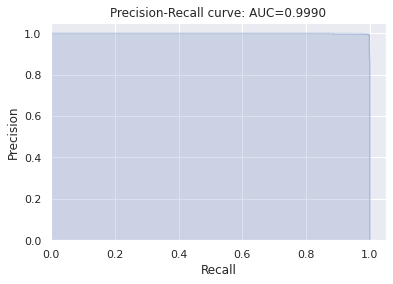

In [11]:
##################
# XGB classifier
# Long computation in this cell
weights = (trainY == 0).sum() / (1.0 * (trainY == 1).sum())
start = time.time()
if n_gpus == 0:
    clf = xgb.XGBClassifier(max_depth = 3, #scale_pos_weight = weights, 
                            n_jobs = 4)
else:
    clf = xgb.XGBClassifier(max_depth = 3, #scale_pos_weight = weights, 
                            n_jobs = 4, tree_method = 'gpu_hist')

clf.fit(trainX, trainY)

print(type(testX))
y_pred = clf.predict(testX)
print(time.time()-start,'secs clf time')
print(type(testY));print(type(y_pred))
print("Classification Report for XGBoost Classifier: \n", classification_report(testY, y_pred))
print("Confusion Matrix of XGBoost Classifier: \n", confusion_matrix(testY, y_pred))
plot_precision_recall(testY, clf.predict_proba(testX)[:,1])

# Orig Confusion Matrix of XGBoost Classifier:
# [[552394      9]
#  [     6   1672]]

In [12]:
#Examine testX, testY, y_pred len
testX.shape[0], testY.shape[0], len(y_pred)

(554081, 554081, 554081)

In [13]:
#Examine trainX, trainY
concat([DataFrame(trainX).tail(200),Series(trainY).tail(200)],axis=1)

,step,type,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,errorBalanceOrig,errorBalanceDest,0
52910,9,1,109702.12,0.0,0.0,3383542.24,3493244.36,109702.12,4.656612873e-10,<NA>
102747,10,1,137094.54,0.0,0.0,2155270.37,2167403.85,137094.54,124961.06,<NA>
119582,11,1,104424.53,0.0,0.0,637192.48,771950.71,104424.53,-30333.7,<NA>
143189,11,0,812456.05,0.0,0.0,2957178.13,3313443.52,812456.05,456190.66,<NA>
158044,12,1,216472.06,13077.0,0.0,1028610.0,1691566.45,203395.06,-446484.39,<NA>
162806,12,1,580723.52,206412.0,0.0,0.0,580723.52,374311.52,0.0,<NA>
219619,13,1,164771.05,5617.0,0.0,384480.0,447370.25,159154.05,101880.8,<NA>
251147,14,1,47130.59,0.0,0.0,862912.53,542612.49,47130.59,367430.63,<NA>
264431,15,1,87532.81,514565.0,427032.19,1384037.54,1512661.43,0.0,-41091.08,<NA>
293026,15,1,68829.16,355767.78,286938.62,7638953.0,7707782.15,0.0,0.010000001,<NA>


In [14]:
#Examine testX, testY, y_pred
concat([DataFrame(testX).tail(50),Series(testY).tail(50),Series(y_pred).tail(50)],axis=1)

,step,type,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,errorBalanceOrig,errorBalanceDest,0,1
24500,8,1,64431.46,0.0,0.0,234016.97,623377.01,64431.46,-324928.58,<NA>,<NA>
274215,15,0,390662.12,353242.88,0.0,0.0,774947.79,37419.24,-384285.67,<NA>,<NA>
350753,17,0,968677.96,0.0,0.0,4325194.47,5293872.42,968677.96,0.010000001,<NA>,<NA>
351330,17,1,24240.1,15273.0,0.0,1440938.61,1465178.71,8967.1,2.328306437e-10,<NA>,<NA>
490826,19,0,11441.35,67070.0,55628.65,2000445.07,1937186.91,0.0,74699.51,<NA>,<NA>
554031,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0,0
554032,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0,0
554033,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0,0
554034,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0,0
554035,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0,0


## PyTorch classifier

In [15]:
##################
# PyTorch classifier
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [16]:
print(X.shape)
X.head()

(2770409, 9)


,step,type,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,errorBalanceOrig,errorBalanceDest
2,1,0,181.00,181.0,0.0,0.0,0.00,0.00,181.0
3,1,1,181.00,181.0,0.0,21182.0,0.00,0.00,21363.0
15,1,1,229133.94,15325.0,0.0,5083.0,51513.44,213808.94,182703.5
19,1,0,215310.30,705.0,0.0,22425.0,0.00,214605.30,237735.3
24,1,0,311685.89,10835.0,0.0,6267.0,2719172.89,300850.89,-2401220.0


In [17]:
scaler = StandardScaler()

columns = X.columns; isErrorCols = False
for name in columns:
    print(name)
    if name[0:5] == 'error': isErrorCols = True
    X[name] = X[name].fillna(0)

cols = ['amount','oldBalanceOrig','newBalanceOrig','oldBalanceDest','newBalanceDest']

DFtoScale = X[cols]
if False:
    dataScaled= scaler.fit_transform(DFtoScale.to_pandas())
    DFscaled  = pd.DataFrame(data=dataScaled,columns=cols)
    DFscaled.head()
else:
    #DFscaled = DFtoScale.to_pandas()
    DFtoScale

step
type
amount
oldBalanceOrig
newBalanceOrig
oldBalanceDest
newBalanceDest
errorBalanceOrig
errorBalanceDest


In [18]:
gdf = concat([X[['step','type']],DataFrame(DFtoScale)],axis=1)
gdf.head()

,step,type,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest
2,1,0,181.00,181.0,0.0,0.0,0.00
3,1,1,181.00,181.0,0.0,21182.0,0.00
15,1,1,229133.94,15325.0,0.0,5083.0,51513.44
19,1,0,215310.30,705.0,0.0,22425.0,0.00
24,1,0,311685.89,10835.0,0.0,6267.0,2719172.89


In [19]:
X, y = gdf, Y
vc = y.value_counts() #Let's see the imbalance 
print('y fraud density = ',vc[1]/vc[0],"or 1 in",np.round(vc[0]/vc[1],1))

print(type(X),type(y))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


y fraud density =  0.0029733588782258754 or 1 in 336.3
<class 'cudf.core.dataframe.DataFrame'> <class 'cudf.core.series.Series'>
(2216327, 7) (554082, 7) (2216327,) (554082,)


In [20]:
if n_gpus == 0: 
    X_train, y_train = X_train.values, y_train.values
else: 
    X_train, X_test = X_train.as_gpu_matrix(), X_test.as_gpu_matrix()

In [21]:
print(type(X_train), type(X_test))
print(X_train.shape, X_test.shape)

<class 'numba.cuda.cudadrv.devicearray.DeviceNDArray'> <class 'numba.cuda.cudadrv.devicearray.DeviceNDArray'>
(2216327, 7) (554082, 7)


In [22]:
EPOCHS = 5
BATCH_SIZE = 64*2*2*2
LEARNING_RATE = .001

## train data
class trainData(Dataset):

    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    
train_data = trainData(torch.FloatTensor(X_train),
                       torch.FloatTensor(y_train))
## test data    
class testData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    
if n_gpus == 0: 
    test_data = testData(torch.FloatTensor(X_test.values))
else:           
    test_data = testData(torch.FloatTensor(X_test))

In [23]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        # Number of input features is X_train.shape[1].
        self.layer_1 = nn.Linear(X_train.shape[1], 64) 
        self.layer_2 = nn.Linear(64, 32)
        self.layer_3 = nn.Linear(32, 32)
        self.layer_4 = nn.Linear(32, 16)
        self.layer_out = nn.Linear(16, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(32)
        self.batchnorm3 = nn.BatchNorm1d(32)
        self.batchnorm4 = nn.BatchNorm1d(16)
   
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        #x = self.dropout(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        #x = self.dropout(x)
        x = self.relu(self.layer_3(x))
        #x = self.batchnorm3(x)
        #x = self.dropout(x)
        x = self.relu(self.layer_4(x))
        #x = self.batchnorm4(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        return x


In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = binaryClassification()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

cuda:0
binaryClassification(
  (layer_1): Linear(in_features=7, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=32, bias=True)
  (layer_3): Linear(in_features=32, out_features=32, bias=True)
  (layer_4): Linear(in_features=32, out_features=16, bias=True)
  (layer_out): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [26]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))
    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)    
    return acc

import time
model.train()
for e in range(1, EPOCHS+1):
    start = time.time()
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')
    print(time.time()-start)

Epoch 001: | Loss: 0.01431 | Acc: 99.551
26.626123428344727
Epoch 002: | Loss: 0.00456 | Acc: 99.980
26.231738567352295
Epoch 003: | Loss: 0.00414 | Acc: 99.979
26.279011487960815
Epoch 004: | Loss: 0.00385 | Acc: 99.985
25.764668703079224
Epoch 005: | Loss: 0.00394 | Acc: 99.986
26.233888149261475


In [27]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [28]:
y_test_ndarray = asarray(y_test) 
y_pred_ndarray = array(y_pred_list)
print(len(y_test_ndarray),len(y_pred_ndarray))

554082 554082


In [29]:
#type that works for call below: 'numpy.ndarray'
if n_gpus == 1:
    y_test_ndarray, y_pred_ndarray = y_test_ndarray.get(), y_pred_ndarray.get()
print(confusion_matrix(y_test_ndarray, y_pred_ndarray))
print(classification_report(y_test_ndarray, y_pred_ndarray))


[[552432      4]
 [   943    703]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552436
           1       0.99      0.43      0.60      1646

    accuracy                           1.00    554082
   macro avg       1.00      0.71      0.80    554082
weighted avg       1.00      1.00      1.00    554082

